In [193]:
from google.cloud import storage
import funcy as fn
import pandas as pd
import altair as alt
import plotly.express as px
import json
import re
from typing import Dict
from pydantic import BaseSettings, Field
from collectionish import AttyDict

In [74]:
class GoogleConfig(BaseSettings):
    credentials: str = Field(..., env="GOOGLE_APPLICATION_CREDENTIALS")
    project: str = Field(default="avista-302012", env="GOOGLE_PROJECT")
    bucket: str = Field(default="avista-flights", env="GOOGLE_BUCKET")
    folder: str = Field(default="flights", env="GOOGLE_FOLDER")

class NotebookConfig(BaseSettings):
    google = GoogleConfig()

config = NotebookConfig()

In [85]:
class Storage:
    def __init__(self, project: str, bucket: str):
        self.project = project
        self.bucket_name = bucket
        client = storage.Client(project=project)
    
    @property
    def bucket(self):
        return client.get_bucket(self.bucket_name)
    
    
gcs = Storage(
    project=config.google.project,
    bucket=config.google.bucket
)

In [88]:
files = fn.lmap(lambda blob: blob.name, gcs.bucket.list_blobs(prefix=config.google.folder))
files[0]

'flights/2021/1/22/828b2586-fe14-437e-8457-549cfe34a7df.jsonl'

In [90]:
blobs = fn.lmap(lambda file: gcs.bucket.get_blob(file), files)
blobs[0]

<Blob: avista-flights, flights/2021/1/22/828b2586-fe14-437e-8457-549cfe34a7df.jsonl>

In [214]:
data = fn.flatten(fn.map(lambda x: x.download_as_string(), blobs))

In [215]:
RECORD_EXPR = re.compile(r"({.+)")
records = fn.flatten(fn.map(lambda x: RECORD_EXPR.search(str(x)).groups()[0].split("\\n"), data))

@fn.ignore(json.JSONDecodeError)
def parse_or_ignore_jsonlines(row: str) -> AttyDict:
    if isinstance(row, str):
        return AttyDict(json.loads(row))
    else:
        return row

In [216]:
parsed = fn.lmap(lambda x: parse_or_ignore_jsonlines(x), records)
len(parsed)

4133

In [232]:
flights = fn.lfilter(lambda x: fn.notnone(x), parsed)
flights[0]

{'flight_date': '2021-01-23',
 'flight_status': 'active',
 'departure': {'airport': 'Auckland International',
  'timezone': 'Pacific/Auckland',
  'iata': 'AKL',
  'icao': 'NZAA',
  'terminal': 'I',
  'gate': '1',
  'baggage': '',
  'delay': 9,
  'scheduled': '2021-01-23T10:40:00Z',
  'estimated': '2021-01-23T10:40:00Z',
  'actual': '2021-01-23T10:49:00Z',
  'estimated_runway': '2021-01-23T10:49:00Z',
  'actual_runway': '2021-01-23T10:49:00Z'},
 'arrival': {'airport': 'Kingsford Smith',
  'timezone': 'Australia/Sydney',
  'iata': 'SYD',
  'icao': 'YSSY',
  'terminal': '1',
  'gate': '37',
  'baggage': '12',
  'delay': 0,
  'scheduled': '2021-01-23T12:20:00Z',
  'estimated': '2021-01-23T12:20:00Z',
  'actual': '0001-01-01T00:00:00Z',
  'estimated_runway': '0001-01-01T00:00:00Z',
  'actual_runway': '0001-01-01T00:00:00Z'},
 'airline': {'name': 'Air New Zealand', 'iata': 'NZ', 'icao': 'ANZ'},
 'flight': {'number': '103', 'iata': 'NZ103', 'icao': 'ANZ103'}}

In [235]:
def make_row(row):
    return AttyDict({
        "id": row.flight.number,
        "date": row.flight_date,
        "status": row.flight_status,
        "airport_departed_code": row.departure.iata,
        "airport_departed": row.departure.airport,
        "scheduled_departure": row.departure.scheduled,
        "actual_departure": row.departure.actual,
        "airport_arrival_code": row.arrival.iata,    
        "airport_arrived": row.arrival.airport,
        "scheduled_arrival": row.arrival.scheduled,
        "actual_arrival": row.arrival.actual,    
        "delay": row.departure.delay,
        "airline": row.airline.name
    })

df = pd.DataFrame(fn.lmap(lambda row: make_row(row), flights))
df.head()

,id,date,status,airport_departed_code,airport_departed,scheduled_departure,actual_departure,airport_arrival_code,airport_arrived,scheduled_arrival,actual_arrival,delay,airline
0,103,2021-01-23,active,AKL,Auckland International,2021-01-23T10:40:00Z,2021-01-23T10:49:00Z,SYD,Kingsford Smith,2021-01-23T12:20:00Z,0001-01-01T00:00:00Z,9,Air New Zealand
1,9514,2021-01-23,active,AKL,Auckland International,2021-01-23T10:40:00Z,2021-01-23T10:49:00Z,SYD,Kingsford Smith,2021-01-23T12:20:00Z,0001-01-01T00:00:00Z,9,Alaska Airlines
2,1911,2021-01-23,active,NAN,Nadi International,2021-01-23T10:00:00Z,2021-01-23T10:11:00Z,SYD,Kingsford Smith,2021-01-23T13:40:00Z,0001-01-01T00:00:00Z,11,Fiji Airways
3,7520,2021-01-23,unknown,PVG,Shanghai Pudong International,2021-01-23T05:35:00Z,0001-01-01T00:00:00Z,SYD,Kingsford Smith,2021-01-23T18:40:00Z,0001-01-01T00:00:00Z,0,Qantas
4,426,2021-01-23,active,MEL,Tullamarine,2021-01-23T09:00:00Z,2021-01-23T09:07:00Z,SYD,Kingsford Smith,2021-01-23T10:20:00Z,0001-01-01T00:00:00Z,7,Qantas


In [260]:
df[df.airport_departed_code == "LHR"]

,id,date,status,airport_departed_code,airport_departed,scheduled_departure,actual_departure,airport_arrival_code,airport_arrived,scheduled_arrival,actual_arrival,delay,airline


In [261]:
departures = (
    df
    .drop_duplicates("id")
    .groupby("airport_departed")
    .agg(count=("id", "count"))
    .reset_index()
    .sort_values("count")
)
departures.head()

,airport_departed,count
64,Xiamen,1
30,Hangzhou,1
17,Cooma,1
14,Chu-Bu Centrair International (Central Japan I...,1
42,Mudgee,1


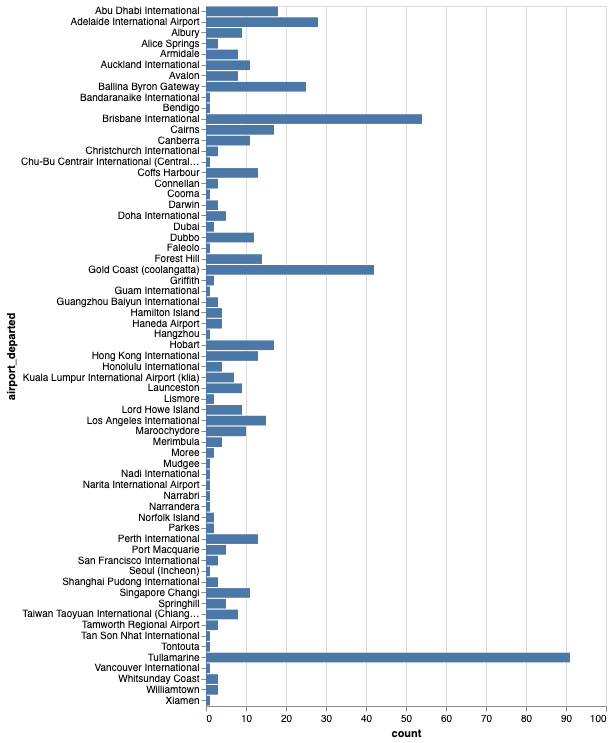

In [262]:
alt.Chart(departures).mark_bar().encode(
    x=alt.X("count:Q"),
    y=alt.Y("airport_departed"),
    tooltip=departures.columns.tolist()
).properties(
    height=700
)